# Problem 7 : PSF deconvolution with Neural Networks - Data
This problem aims to tackle the processing of blurry and noisy telescope image by training neural networks to deconvolve an image's PSF (Point Spread Function)

In [1]:
import sys
sys.path.insert(0, "../")
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.desi_image_downloader import get_image
from utils.display_utils import display
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, AiryDisk2DKernel

plt.style.use("science")

In [2]:
# CONSTANTS
RA_bounds = (115, 260)
DEC_bounds = (0, 80)
psfwidth_bounds = (4, 8)

npix=511

## Legacy Survey data

We will be working with cutouts from the DESI Legacy Imaging Survey, a catalogue of light in multiple bands from very wide areas of the sky.

TODO: toss images with pixels above saturation mask value, and those with sum of all pixels below threshold

### A random patch of sky
Let's select random RA and DEC coordinates within the intervals covered by the survey and see what comes up:

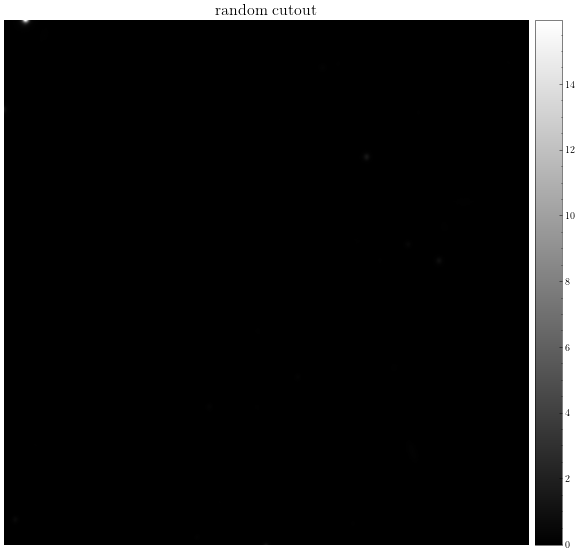

(<matplotlib.image.AxesImage at 0x7f737cfc3730>,
 Text(0.5, 1.0, 'random cutout'))

In [3]:
RA = np.random.uniform(low=RA_bounds[0], high=RA_bounds[1])
DEC = np.random.uniform(low=DEC_bounds[0], high=DEC_bounds[1])

rand_cutout, header = get_image(RA, DEC, size=npix)

display(rand_cutout, axis=False, title="random cutout")

### A bright star
Let's now look at the coordinates of Pollux, a star in the Gemini constellation and one of the brightest in the sky:

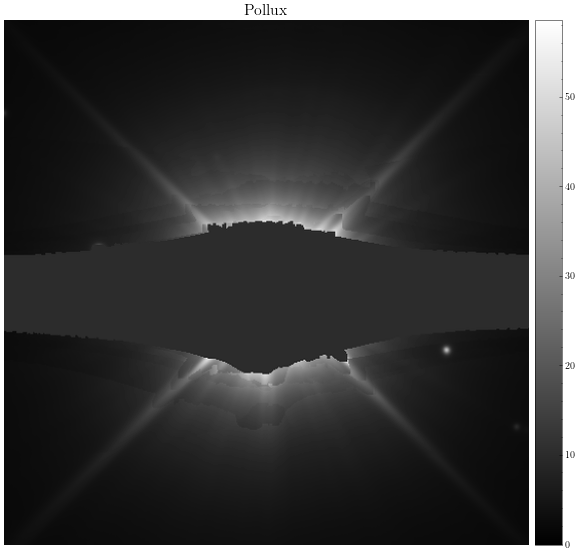

(<matplotlib.image.AxesImage at 0x7f7391f5ee50>, Text(0.5, 1.0, 'Pollux'))

In [4]:
# Pollux coordinates
RA = 116.3260
DEC = 28.0265

pollux_cutout, header = get_image(RA, DEC, size=npix)

display(pollux_cutout, axis=False, title="Pollux")

## Selecting good data
We would like to avoid dark patches without objects, as well as patches containing bright stars or their masks. We can filter our selection with flux thresholds:

In [5]:
def square_window(aperture_frac=0.75):
	
	window = np.zeros(npix)
	aperture = npix * aperture_frac
	cutout_side = np.arange(-npix/2, npix/2)
	
	r = np.abs(cutout_side)
	opening = r < aperture / 2
	window[opening == 1.0] = 1.

	window = np.outer(window, window)

	return window


def clean_selection(min_sum=15., sat_pixel=9., aperture_frac=1.):
	"""
	Fetch a random cutout from the Legacy Survey, ensuring that some 
	quality conditions are met
	
	:param min_sum: lower threshold for the sum of all pixel values
	:param sat_pixel: saturation value of bright star masks
	:param aperture_frac: fraction of cutout defining a centered square mask, in which we check for sufficient signal
	"""
	window = square_window(aperture_frac)
	
	while True:
		RA = np.random.uniform(low=RA_bounds[0], high=RA_bounds[1])
		DEC = np.random.uniform(low=DEC_bounds[0], high=DEC_bounds[1])
		
		cutout, header = get_image(RA, DEC, size=npix)
		
		if np.sum(window * cutout) > min_sum and np.all(cutout < sat_pixel):
			break
		print("bad cutout, retrying...")
		
	return cutout

bad cutout, retrying...
bad cutout, retrying...


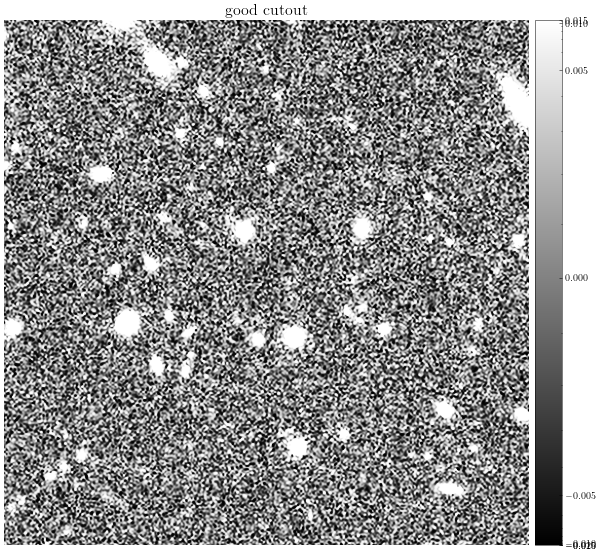

(<matplotlib.image.AxesImage at 0x7f737742aaf0>, Text(0.5, 1.0, 'good cutout'))

In [7]:
good_cutout = clean_selection()

display(good_cutout, axis=False, title="good cutout", norm="HistEqStretch")

## Convolving with a PSF and adding noise


In [8]:
def corrupt_image(image, psf="gaussian", radius=None, psf_size=npix, noise="gaussian", noise_scale=0.02):

	# PSF first
	if psf is not None:
		if psf == "gaussian":
			if radius is None:
				width = np.random.uniform(low=psfwidth_bounds[0], high=psfwidth_bounds[1])
				radius = width**2 / (8*np.log(2))
			print(radius)
			kernel = Gaussian2DKernel(x_stddev=radius, x_size=psf_size, y_size=psf_size)
		elif psf == "airy":
			kernel = AiryDisk2DKernel(radius=radius, x_size=psf_size, y_size=psf_size)
		else:
			raise ValueError(f"psf of type '{psf}' not implemented")
		
		if kernel.shape[0] < npix // 10:
			image = convolve(image, kernel)     # direct convolution, better for small kernels
		else:
			image = convolve_fft(image, kernel) # FFT convolution, better for large kernels
			
	# Noise
	if noise is not None:
		if noise == "poisson":
			mask = np.random.poisson(noise_scale, size=(npix, npix))
		elif noise == "gaussian":
			mask = np.random.normal(loc=0., scale=noise_scale*np.max(np.abs(image)), size=(npix, npix))
		else:
			raise ValueError(f"noise of type '{noise}' not implemented")
		image += mask

	return image, kernel.array

8.668304662338926


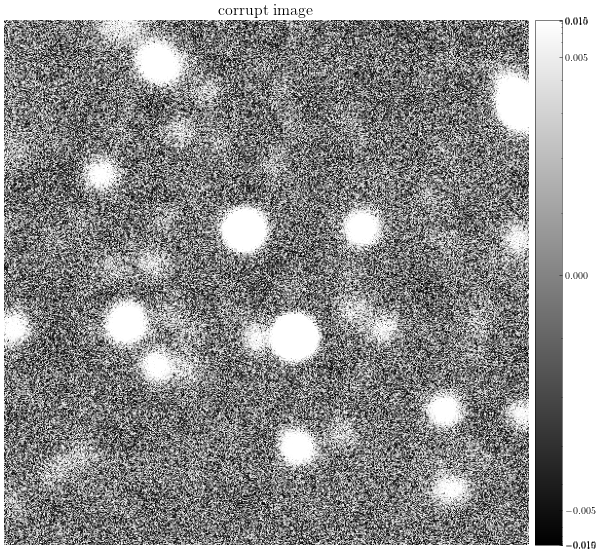

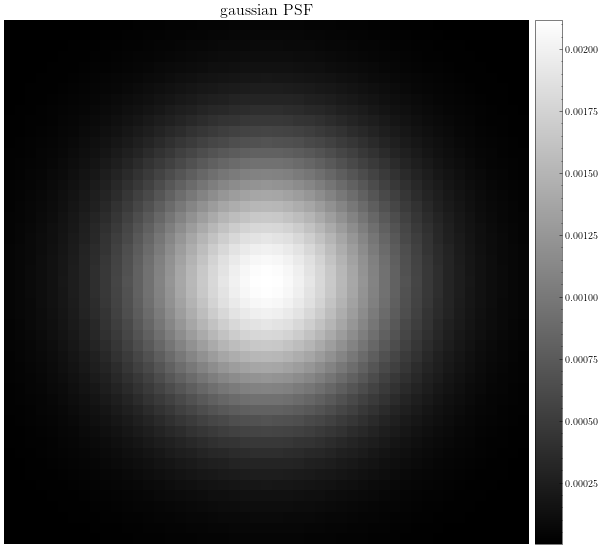

(<matplotlib.image.AxesImage at 0x7f737745c880>,
 Text(0.5, 1.0, 'gaussian PSF'))

In [9]:
psf = "gaussian"
radius = None
noise = "gaussian"

bad_image, kernel = corrupt_image(good_cutout, psf=psf, radius = radius, psf_size=49, noise=noise)

display(bad_image, axis=False, title="corrupt image", norm="HistEqStretch")
display(kernel, axis=False, title=f"{psf} PSF")

None


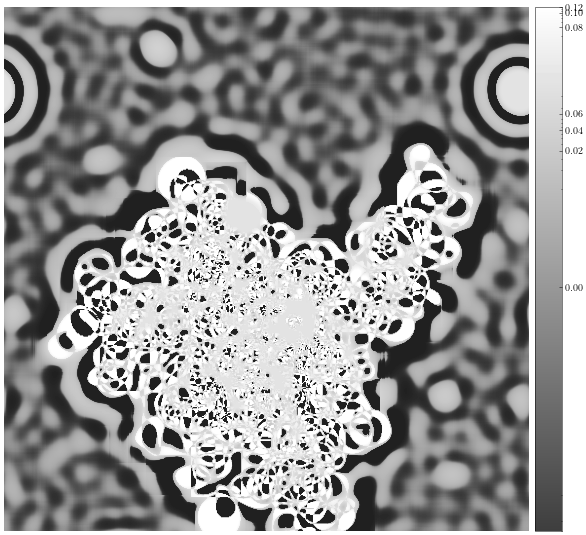

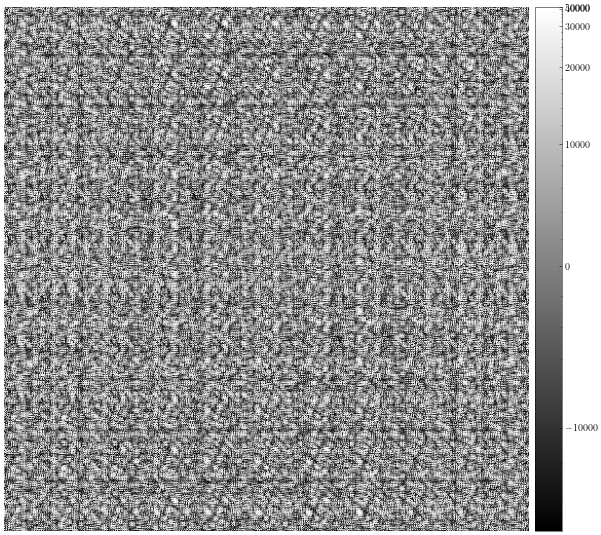

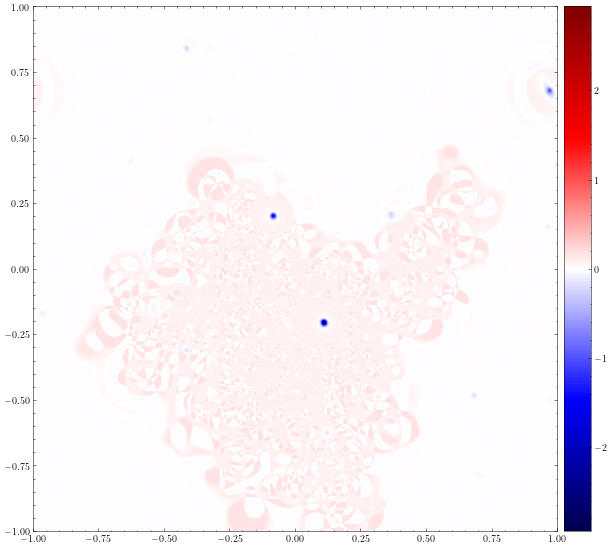

(<matplotlib.image.AxesImage at 0x7f737245eca0>, None)

In [14]:
from classical_solution_lucyrichardson import deconvolve_lucyrichardson
from classical_solution_fft import deconvolve_fft

# filter_epsilon = np.max(bad_image)*0.02/10000
filter_epsilon = None
print(filter_epsilon)
deconvd_lr = deconvolve_lucyrichardson(bad_image, kernel, n_iter=100, filter_epsilon=filter_epsilon)
deconvd_fft = deconvolve_fft(bad_image, kernel)

display(deconvd_lr, axis=False, norm="HistEqStretch")
display(deconvd_fft, axis=False, norm="HistEqStretch")

display(deconvd_lr - good_cutout, cmap="seismic", norm="Centered")